 The main aim of this project is to create an automated system using Python and Natural Language Processing (NLP) techniques to analyze the sentiment of feedback data. The ultimate purpose is to furnish the WRA with meaningful observations that can aid in making informed decisions and enhance the feedback experience of stakeholders. Furthermore, this project will give the student a chance to work alongside other WRA members, allowing them to acquire practical knowledge and experience in utilizing NLP techniques to influence decision-making in a government department.







In [1]:
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import itertools
nltk.download('vader_lexicon')


from bs4 import BeautifulSoup
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk import sent_tokenize, word_tokenize, pos_tag
from itertools import cycle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics import roc_curve
from sklearn.pipeline import Pipeline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [2]:
#!pip install swifter

***Importing Dataset***

In [3]:
data = pd.read_csv("/content/feedback.csv")
data

,Unnamed: 0,Compliment
0,NaN,Compliment
1,NaN,Compliment
2,NaN,Compliment
3,NaN,Compliment
4,NaN,Compliment
...,...,...
2960,As feedback I thought the thee sessions were t...,Compliment
2961,Can I also say in general that I have found th...,Compliment
2962,As I said on the call earlier – you have reall...,Compliment
2963,Your guidelines do not appear to indicate whet...,Grumble


In [4]:
df = data.rename(columns={'Unnamed: 0': 'feedback', 'Compliment': 'feedtype'}).dropna()
df

,feedback,feedtype
13,It was easy but I think the Form can be improv...,Neutral
18,Shorten registration times. It's automatic ove...,Grumble
20,BECAUSE A LOT OF THE INFORMATION BEING REQUEST...,Grumble
21,Why does it take 10 days to approve a registra...,Neutral
22,The website is easy to use however the turnaro...,Neutral
...,...,...
2960,As feedback I thought the thee sessions were t...,Compliment
2961,Can I also say in general that I have found th...,Compliment
2962,As I said on the call earlier – you have reall...,Compliment
2963,Your guidelines do not appear to indicate whet...,Grumble


In [5]:
feedback= df['feedtype']
pos_feed =0
neg_feed=0
neutral=0

for f in feedback:
  if f=='Compliment':
    pos_feed+=1
  elif f=='Grumble':
    neg_feed+=1
  elif f=='Neutral':
    neutral+=1
print(pos_feed)
print(neg_feed)
print(neutral)

739
409
363


***Removing Punctuation***

In [6]:
import string
string.punctuation
def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in string.punctuation])
    return punctuationfree
#storing the puntuation free text
df['feedback']= df['feedback'].apply(lambda x:remove_punctuation(x))
df.head()

,feedback,feedtype
13,It was easy but I think the Form can be improv...,Neutral
18,Shorten registration times Its automatic over ...,Grumble
20,BECAUSE A LOT OF THE INFORMATION BEING REQUEST...,Grumble
21,Why does it take 10 days to approve a registra...,Neutral
22,The website is easy to use however the turnaro...,Neutral


In [7]:
df['feedback'] = df['feedback'].str.lower()
df['feedtype'] = df['feedtype'].str.lower()

Text(0, 0.5, '')

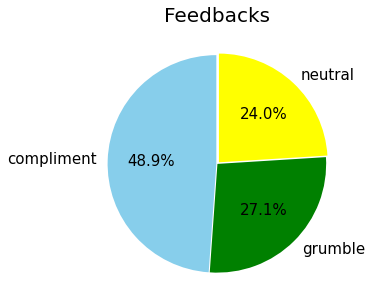

In [8]:
feed_df = df["feedtype"]
plt.figure(figsize=(5,5))
feed_df.value_counts().plot(kind="pie", autopct="%1.1f%%", textprops={"fontsize": 15}, startangle=90, explode=(0.01, 0,0.02), colors=["skyblue","green","yellow"])
plt.title("Feedbacks", fontsize=20)
plt.ylabel("")

The distribution of feedback sentiments received is illustrated by the pie chart, which classifies feedback into positive, negative, and neutral categories. As per the chart, the majority of feedback received was positive, constituting 48.9% of the total feedback, with negative feedback following at 27.1% of the total feedback. A smaller proportion of neutral feedback, amounting to 24.0% of the total feedback, can also be observed.


In [9]:
import seaborn as sns

[Text(0, 0, '739'), Text(0, 0, '410'), Text(0, 0, '363')]

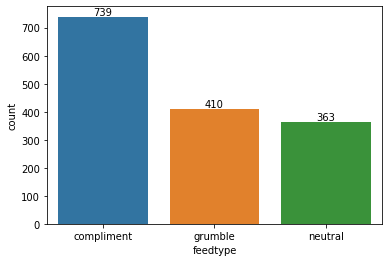

In [10]:
bar_plot = sns.countplot(x=df['feedtype'],order=df['feedtype'].value_counts(ascending=False).index);
values = df['feedtype'].value_counts(ascending=False).values
bar_plot.bar_label(container=bar_plot.containers[0], labels=values)

In [11]:
df

,feedback,feedtype
13,it was easy but i think the form can be improv...,neutral
18,shorten registration times its automatic over ...,grumble
20,because a lot of the information being request...,grumble
21,why does it take 10 days to approve a registra...,neutral
22,the website is easy to use however the turnaro...,neutral
...,...,...
2960,as feedback i thought the thee sessions were t...,compliment
2961,can i also say in general that i have found th...,compliment
2962,as i said on the call earlier – you have reall...,compliment
2963,your guidelines do not appear to indicate whet...,grumble


In [12]:
df['len_feedback'] = df['feedback'].apply(len)

In [13]:
df

,feedback,feedtype,len_feedback
13,it was easy but i think the form can be improv...,neutral,154
18,shorten registration times its automatic over ...,grumble,56
20,because a lot of the information being request...,grumble,63
21,why does it take 10 days to approve a registra...,neutral,50
22,the website is easy to use however the turnaro...,neutral,77
...,...,...,...
2960,as feedback i thought the thee sessions were t...,compliment,82
2961,can i also say in general that i have found th...,compliment,140
2962,as i said on the call earlier – you have reall...,compliment,205
2963,your guidelines do not appear to indicate whet...,grumble,441


In the next step, length of each feedback is found to determine the distribution of feedback and identify the patterns in customer feedback. Through the visualisation of the distribution of feedback lengths, it is possible to gain insights into how customers express their feedback, the level of detail they provide, and the general tone and sentiment of their feedback. 

<AxesSubplot:ylabel='Frequency'>

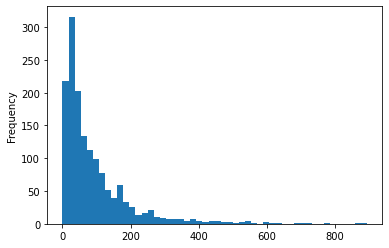

In [14]:
df['len_feedback'].plot(bins=50, kind='hist')

In [15]:
df['len_feedback'].describe()

count    1512.000000
mean       92.601852
std       106.492631
min         0.000000
25%        25.000000
50%        56.000000
75%       119.000000
max       894.000000
Name: len_feedback, dtype: float64

The average feedback length is 92 characters, with the longest feedback consisting of 894 characters. Given that the outlier is unlikely to significantly impact the analysis, it has been retained, as it may serve to aid the organisation in avoiding similar issues in the future.

In [16]:
df[df['len_feedback']==894]['feedback'].iloc[0]

'my solicitor did all the forms when my partner and i bought our new home together we sold both our properties to buy our joint property carols house sold first i then put mine on the market my share of the new house was paid in cash from monies left to me by my mother my house was empty for many months\n i was not happy my solicitor left me to claim the refund i had to go back to her for the tr1 forms as you requested i then had to go back to her for the refund figure\n i felt totally lost as i had to complete this form i had 2 properties temporarily as 1 was in the process of being up for sale no home was a 2nd or holiday home\n the solicitor should be obliged to do the paperwork when my house sold and gave me the £4125 back then i am not happy at this process i am not a solicitor and we are talking tax to the welsh government i wanted to get it right my solicitor should have done it'

***Building word cloud***

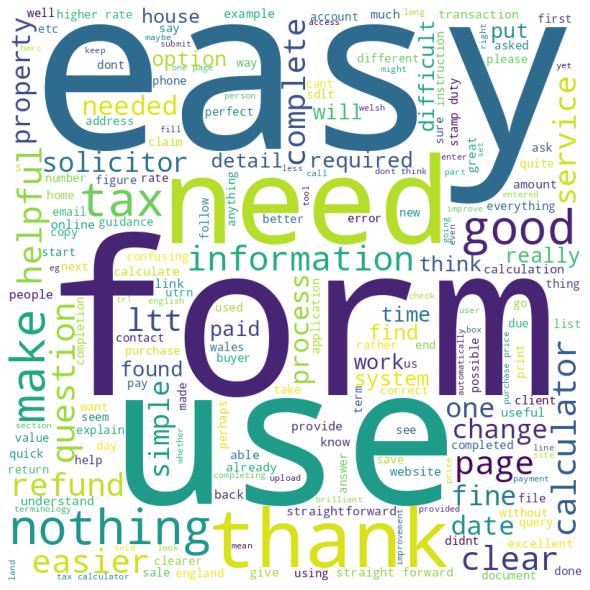

In [17]:
comment_words = ''
stopwords = set(STOPWORDS)
for val in df.feedback:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

Prior to proceeding with further analysis, the data is subjected to cleaning, followed by tokenization. Subsequently, in order to gain a better understanding of the negative feedback, the most frequently occurring words within such feedback(negative feedback) are identified and presented via a bar plot.

***Data Cleaning***

In [18]:
import re

In [19]:
def remove_urls(x):
    cleaned_string = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', str(x), flags=re.MULTILINE)
    return cleaned_string 

In [20]:
def deEmojify(x):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'', x)

In [21]:
def remove_symbols(x):
    cleaned_string = re.sub(r"[^a-zA-Z0-9]+", ' ', x)
    return cleaned_string 

In [22]:
def unify_whitespaces(x):
    cleaned_string = re.sub(' +', ' ', x)
    return cleaned_string

In [23]:
import swifter

df['feedback'] = df['feedback'].swifter.apply(remove_urls)
df['feedback'] = df['feedback'].swifter.apply(deEmojify)
df['feedback'] = df['feedback'].swifter.apply(remove_symbols)
df['feedback'] = df['feedback'].swifter.apply(unify_whitespaces)

Pandas Apply:   0%|          | 0/1512 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1512 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1512 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1512 [00:00<?, ?it/s]

In [24]:
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
sp = spacy.load('en_core_web_sm')

StopWords = sp.Defaults.stop_words
StopWords = [x.lower() for x in StopWords]
StopWords.extend(list(stopwords.words('english')))
StopWords = list(set(StopWords))

def remove_stopwords(x):
    
    words = []
    my_list = x
    
    tokenized_my_list = word_tokenize(my_list) 
    words = [w for w in tokenized_my_list if not w in StopWords]
        
    return " ".join(words)

/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [25]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [26]:
df['feedback'] = df['feedback'].apply(lambda x:remove_stopwords(x))

In [27]:
df

,feedback,feedtype,len_feedback
13,easy think form improved adding tick box buyer...,neutral,154
18,shorten registration times automatic bridge,grumble,56
20,lot information requested repetitive,grumble,63
21,10 days approve registration,neutral,50
22,website easy use turnaround time long,neutral,77
...,...,...,...
2960,feedback thought thee sessions right length in...,compliment,82
2961,general found wra helpful dealing technical qu...,compliment,140
2962,said earlier helpful patient pass feedback lin...,compliment,205
2963,guidelines appear indicate 40000 exemption app...,grumble,441


In [28]:
def tokenization(text):
  tokens = re.findall("[\w]+",text)
  return tokens
#apply tokens
df['clean_feedback'] = df['feedback'].apply(lambda x:tokenization(x))

In [29]:
df['clean_feedback']

13      [easy, think, form, improved, adding, tick, bo...
18      [shorten, registration, times, automatic, bridge]
20              [lot, information, requested, repetitive]
21                      [10, days, approve, registration]
22           [website, easy, use, turnaround, time, long]
                              ...                        
2960    [feedback, thought, thee, sessions, right, len...
2961    [general, found, wra, helpful, dealing, techni...
2962    [said, earlier, helpful, patient, pass, feedba...
2963    [guidelines, appear, indicate, 40000, exemptio...
2964                            [hope, says, great, miss]
Name: clean_feedback, Length: 1512, dtype: object

***Analysis after cleaning***

In [30]:
compliment_reviews =df[df['feedtype']=='compliment']['clean_feedback']
compliment_reviews_words = list(itertools.chain(*compliment_reviews))

neutral_reviews =df[df['feedtype']=='neutral']['clean_feedback']
neutral_reviews_words = list(itertools.chain(*neutral_reviews))

grumble_reviews =df[df['feedtype']=='grumble']['clean_feedback']
grumble_reviews_words = list(itertools.chain(*grumble_reviews))

In [31]:
from nltk import collections
compliment_word_freq = collections.Counter(compliment_reviews_words)
neutral_word_freq = collections.Counter(neutral_reviews_words)
grumble_word_freq = collections.Counter(grumble_reviews_words)

Some customers have specifically referenced LTT calculators, and have commented on the lack of clarity regarding tax-related information. These findings may prove valuable to the organisation in guiding future development of their product or service. 

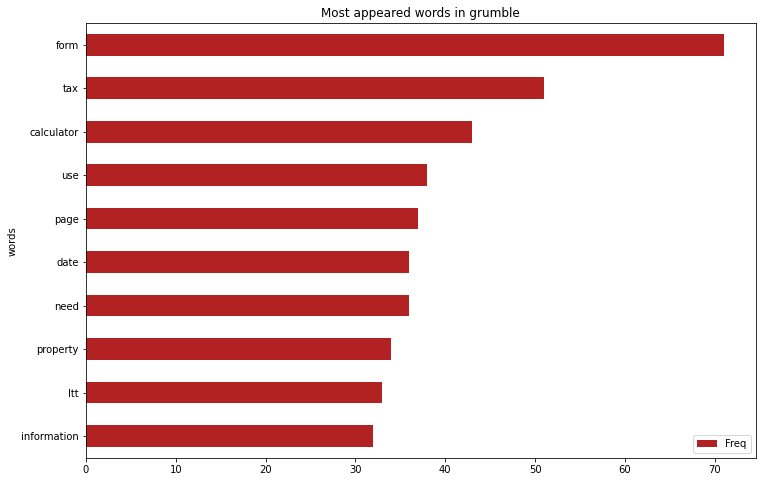

In [34]:
grumble_word_freq_df = pd.DataFrame(grumble_word_freq.most_common(10), columns = ['words','Freq'])
fig , ax = plt.subplots(figsize = (12,8))
grumble_word_freq_df.sort_values(by='Freq').plot.barh(x="words",y="Freq", ax=ax, color = 'Firebrick')
plt.title("Most appeared words in grumble")
plt.show()

While analysing the feedback, it has been observed that certain words, such as "form," "tax," and "calculator," are shared between the negative and neutral feedback. However, the term "LTT" is exclusively present within the negative feedback, suggesting that it requires immediate attention and prioritisation over the issues pertaining to the calculator and tax form.

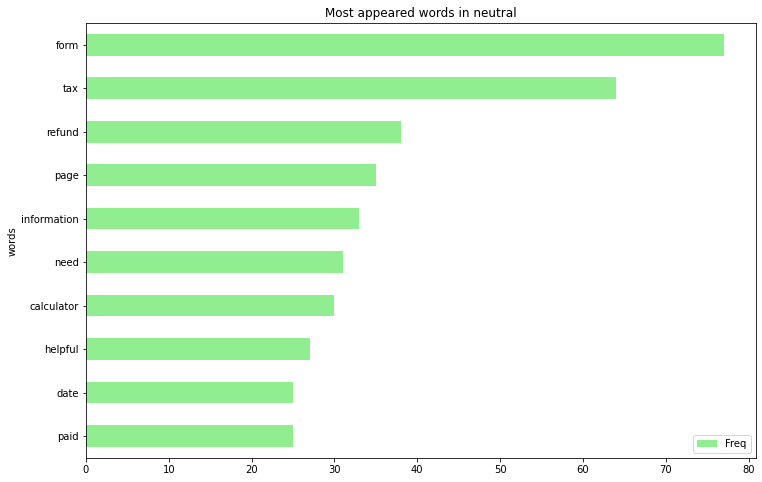

In [33]:
neutral_word_freq_df = pd.DataFrame(neutral_word_freq.most_common(10), columns = ['words','Freq'])
fig , ax = plt.subplots(figsize = (12,8))
neutral_word_freq_df.sort_values(by='Freq').plot.barh(x="words",y="Freq", ax=ax , color = 'lightgreen')
plt.title("Most appeared words in neutral")
plt.show()

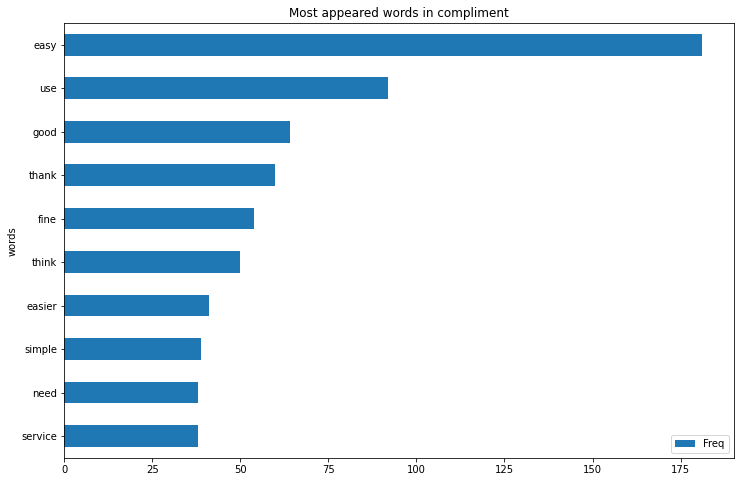

In [32]:
compliment_word_freq_df = pd.DataFrame(compliment_word_freq.most_common(10), columns = ['words','Freq'])
fig , ax = plt.subplots(figsize = (12,8))
compliment_word_freq_df.sort_values(by='Freq').plot.barh(x="words",y="Freq", ax=ax,)
plt.title("Most appeared words in compliment")
plt.show()

***Creating n-grams***

In [35]:
from nltk.tokenize import word_tokenize
from nltk.util import ngrams

def get_ngrams(text, n=2):
    text = str(text)
    n_grams = ngrams(text.split(), n)
    returnVal = []
    
    try:
        for grams in n_grams:
            returnVal.append('-'.join(grams))
    except(RuntimeError):
        pass
        
    return ' '.join(returnVal).strip()

In [36]:
df["bigram_text"] = df["feedback"].swifter.apply(get_ngrams, n=2)

Pandas Apply:   0%|          | 0/1512 [00:00<?, ?it/s]

In [37]:
df

,feedback,feedtype,len_feedback,clean_feedback,bigram_text
13,easy think form improved adding tick box buyer...,neutral,154,"[easy, think, form, improved, adding, tick, bo...",easy-think think-form form-improved improved-a...
18,shorten registration times automatic bridge,grumble,56,"[shorten, registration, times, automatic, bridge]",shorten-registration registration-times times-...
20,lot information requested repetitive,grumble,63,"[lot, information, requested, repetitive]",lot-information information-requested requeste...
21,10 days approve registration,neutral,50,"[10, days, approve, registration]",10-days days-approve approve-registration
22,website easy use turnaround time long,neutral,77,"[website, easy, use, turnaround, time, long]",website-easy easy-use use-turnaround turnaroun...
...,...,...,...,...,...
2960,feedback thought thee sessions right length in...,compliment,82,"[feedback, thought, thee, sessions, right, len...",feedback-thought thought-thee thee-sessions se...
2961,general found wra helpful dealing technical qu...,compliment,140,"[general, found, wra, helpful, dealing, techni...",general-found found-wra wra-helpful helpful-de...
2962,said earlier helpful patient pass feedback lin...,compliment,205,"[said, earlier, helpful, patient, pass, feedba...",said-earlier earlier-helpful helpful-patient p...
2963,guidelines appear indicate 40000 exemption app...,grumble,441,"[guidelines, appear, indicate, 40000, exemptio...",guidelines-appear appear-indicate indicate-400...


In [38]:
df["bigram_text"]

13      easy-think think-form form-improved improved-a...
18      shorten-registration registration-times times-...
20      lot-information information-requested requeste...
21              10-days days-approve approve-registration
22      website-easy easy-use use-turnaround turnaroun...
                              ...                        
2960    feedback-thought thought-thee thee-sessions se...
2961    general-found found-wra wra-helpful helpful-de...
2962    said-earlier earlier-helpful helpful-patient p...
2963    guidelines-appear appear-indicate indicate-400...
2964                      hope-says says-great great-miss
Name: bigram_text, Length: 1512, dtype: object

In [39]:
df["trigram_text"] = df["feedback"].swifter.apply(get_ngrams, n=3)

Pandas Apply:   0%|          | 0/1512 [00:00<?, ?it/s]

In [40]:
df['trigram_text']

13      easy-think-form think-form-improved form-impro...
18      shorten-registration-times registration-times-...
20      lot-information-requested information-requeste...
21              10-days-approve days-approve-registration
22      website-easy-use easy-use-turnaround use-turna...
                              ...                        
2960    feedback-thought-thee thought-thee-sessions th...
2961    general-found-wra found-wra-helpful wra-helpfu...
2962    said-earlier-helpful earlier-helpful-patient h...
2963    guidelines-appear-indicate appear-indicate-400...
2964                      hope-says-great says-great-miss
Name: trigram_text, Length: 1512, dtype: object

In [41]:
bigram_str_list = df['bigram_text'].tolist()
bigram_str = ' '.join(bigram_str_list)

In [42]:
import re
from operator import itemgetter


item1 = itemgetter(1)

def wordfreq(text):
    d = {}
    for word in re.findall(r"\S+", text):
        if word.isdigit():
            continue

        word_lower = word.lower()

       
        if word_lower in d:
            d2 = d[word_lower]
        else:
            d2 = {}
            d[word_lower] = d2

        
        d2[word] = d2.get(word, 0) + 1

    d3 = {}
    for d2 in d.values():
        first = max(d2.items(), key=item1)[0]
        d3[first] = sum(d2.values())

    return d3.items()

freqs1 = wordfreq(bigram_str)

***Creating word cloud for bigrams and trigrams***

In [43]:
type(freqs1)
l = dict(freqs1)
l = dict(sorted(l.items(), key=lambda item: item[1], reverse=True))

In [44]:
l

{'easy-use': 70,
 'straight-forward': 39,
 'stamp-duty': 27,
 'higher-rate': 19,
 'tax-calculator': 17,
 'purchase-price': 16,
 'dont-think': 16,
 'dont-know': 13,
 'complete-form': 11,
 'quick-easy': 11,
 'simple-use': 11,
 'land-tax': 10,
 'tax-rates': 10,
 'easy-complete': 10,
 'main-residence': 10,
 'list-information': 9,
 'information-required': 9,
 'easy-follow': 8,
 'found-easy': 8,
 'second-home': 8,
 'think-easier': 8,
 'tr1-form': 8,
 'filling-form': 8,
 'completing-form': 8,
 'user-friendly': 7,
 'questions-page': 7,
 'land-transaction': 7,
 'easier-find': 7,
 'higher-rates': 7,
 'like-able': 7,
 'information-need': 7,
 'difficult-find': 7,
 'need-able': 7,
 'completion-statement': 7,
 'good-service': 7,
 'tax-paid': 7,
 'extremely-helpful': 6,
 'phone-number': 6,
 'land-registry': 6,
 'welsh-government': 6,
 'straightforward-use': 6,
 'use-thank': 6,
 'plain-english': 6,
 'duty-holiday': 6,
 'cant-think': 6,
 'service-easy': 6,
 'form-easy': 6,
 'need-easy': 6,
 'self-expla

In [45]:
word_cloud1 = WordCloud(width = 2000, height = 1334, random_state=1, background_color='black', colormap='Pastel1', max_words = 75, 
                      collocations=False, normalize_plurals=False).generate_from_frequencies(l)


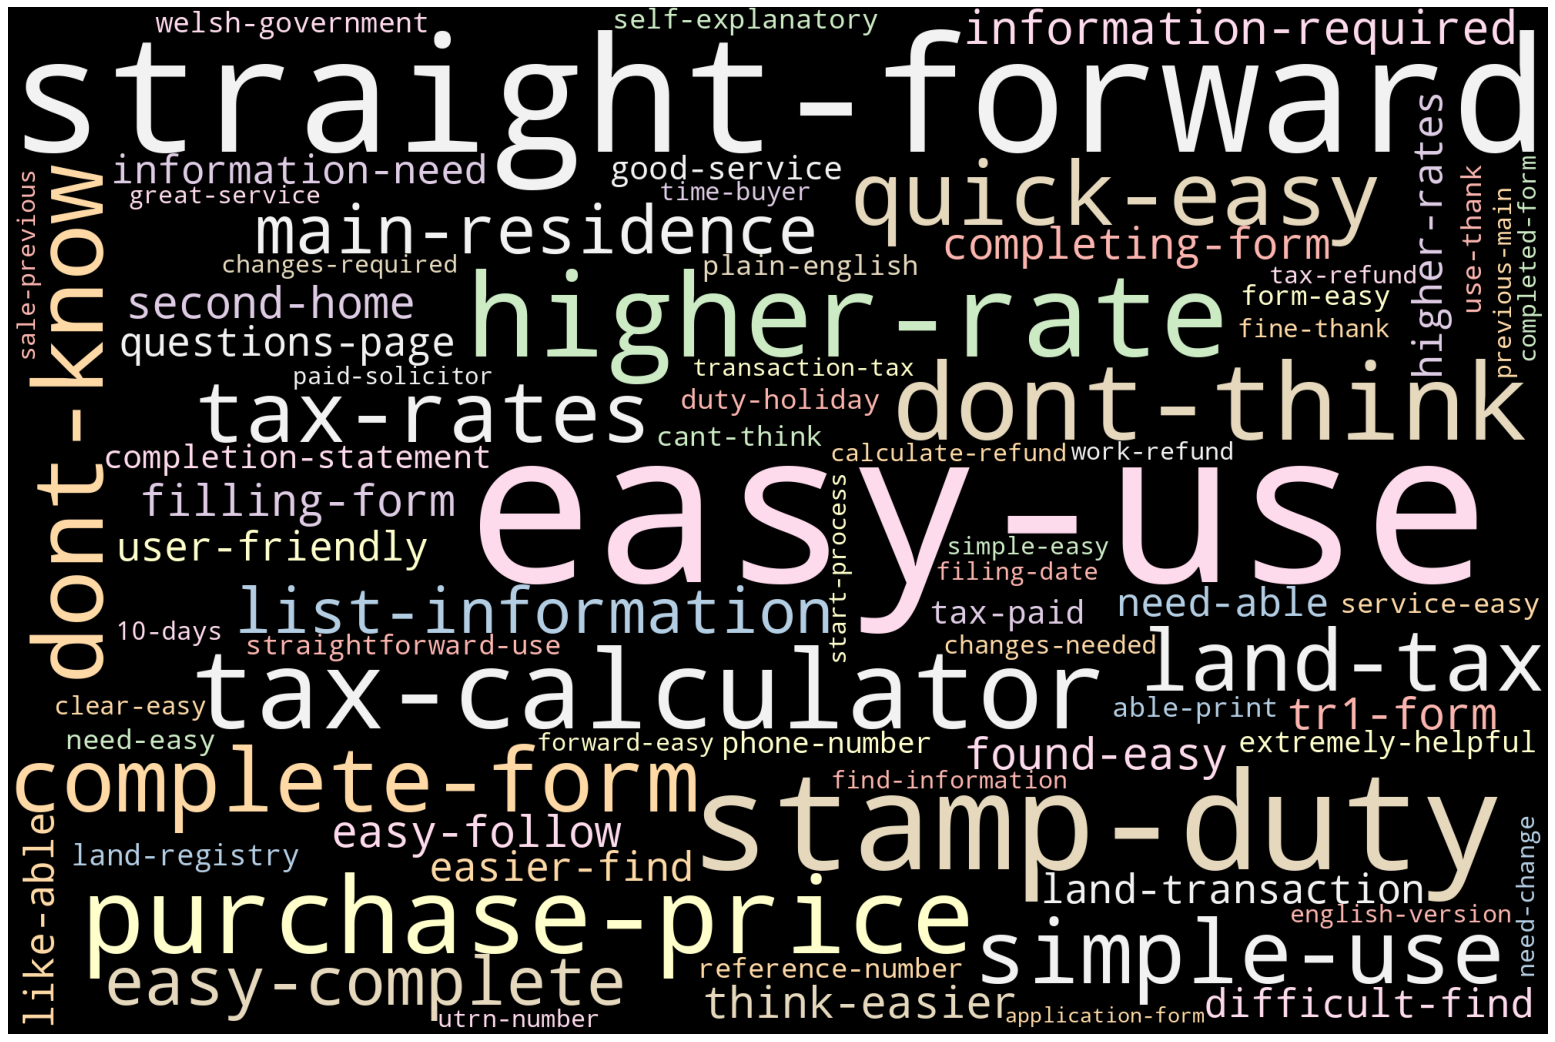

In [46]:
from matplotlib.pyplot import figure
def plot_cloud(word_cloud1):
    fig = plt.figure(figsize=(25, 17), dpi=80)
    plt.tight_layout(pad=0)
    plt.imshow(word_cloud1)
    plt.axis("off")
    plt.box(False)
    plt.show()
    plt.close() 
   
plot_cloud(word_cloud1)

In [47]:
trigram_str_list = df['trigram_text'].tolist()
trigram_str = ' '.join(trigram_str_list)

In [48]:
freqs2 = wordfreq(trigram_str)
type(freqs2)
l1 = dict(freqs2)
l1 = dict(sorted(l1.items(), key=lambda item: item[1], reverse=True))
l1

{'easy-use-thank': 6,
 'stamp-duty-holiday': 6,
 'list-information-need': 5,
 'land-transaction-tax': 5,
 'previous-main-residence': 5,
 'straight-forward-easy': 5,
 'straightforward-easy-use': 4,
 'dont-think-easier': 4,
 'property-purchase-price': 3,
 'found-easy-use': 3,
 'easy-use-dont': 3,
 'set-date-field': 3,
 'date-field-numbers': 3,
 'field-numbers-phone': 3,
 'calculator-easy-use': 3,
 'effective-date-future': 3,
 'date-future-date': 3,
 'future-date-tax': 3,
 'date-tax-rates': 3,
 'tax-rates-alter': 3,
 'rates-alter-total': 3,
 'alter-total-tax': 3,
 'total-tax-different': 3,
 'tax-different-result': 3,
 'different-result-useful': 3,
 'result-useful-newbuild': 3,
 'useful-newbuild-home': 3,
 'newbuild-home-late': 3,
 'home-late-completion': 3,
 'dros-yr-wythnosau': 3,
 'yr-wythnosau-diwethaf': 3,
 'simple-straight-forward': 3,
 'easy-straight-forward': 3,
 'straight-forward-use': 3,
 'refund-calculated-automatically': 3,
 'list-information-required': 3,
 'required-start-proc

In [49]:
word_cloud2 = WordCloud(width = 2000, height = 1334, random_state=1, background_color='black', colormap='Pastel1', max_words = 75, 
                      collocations=False, normalize_plurals=False).generate_from_frequencies(l1) 

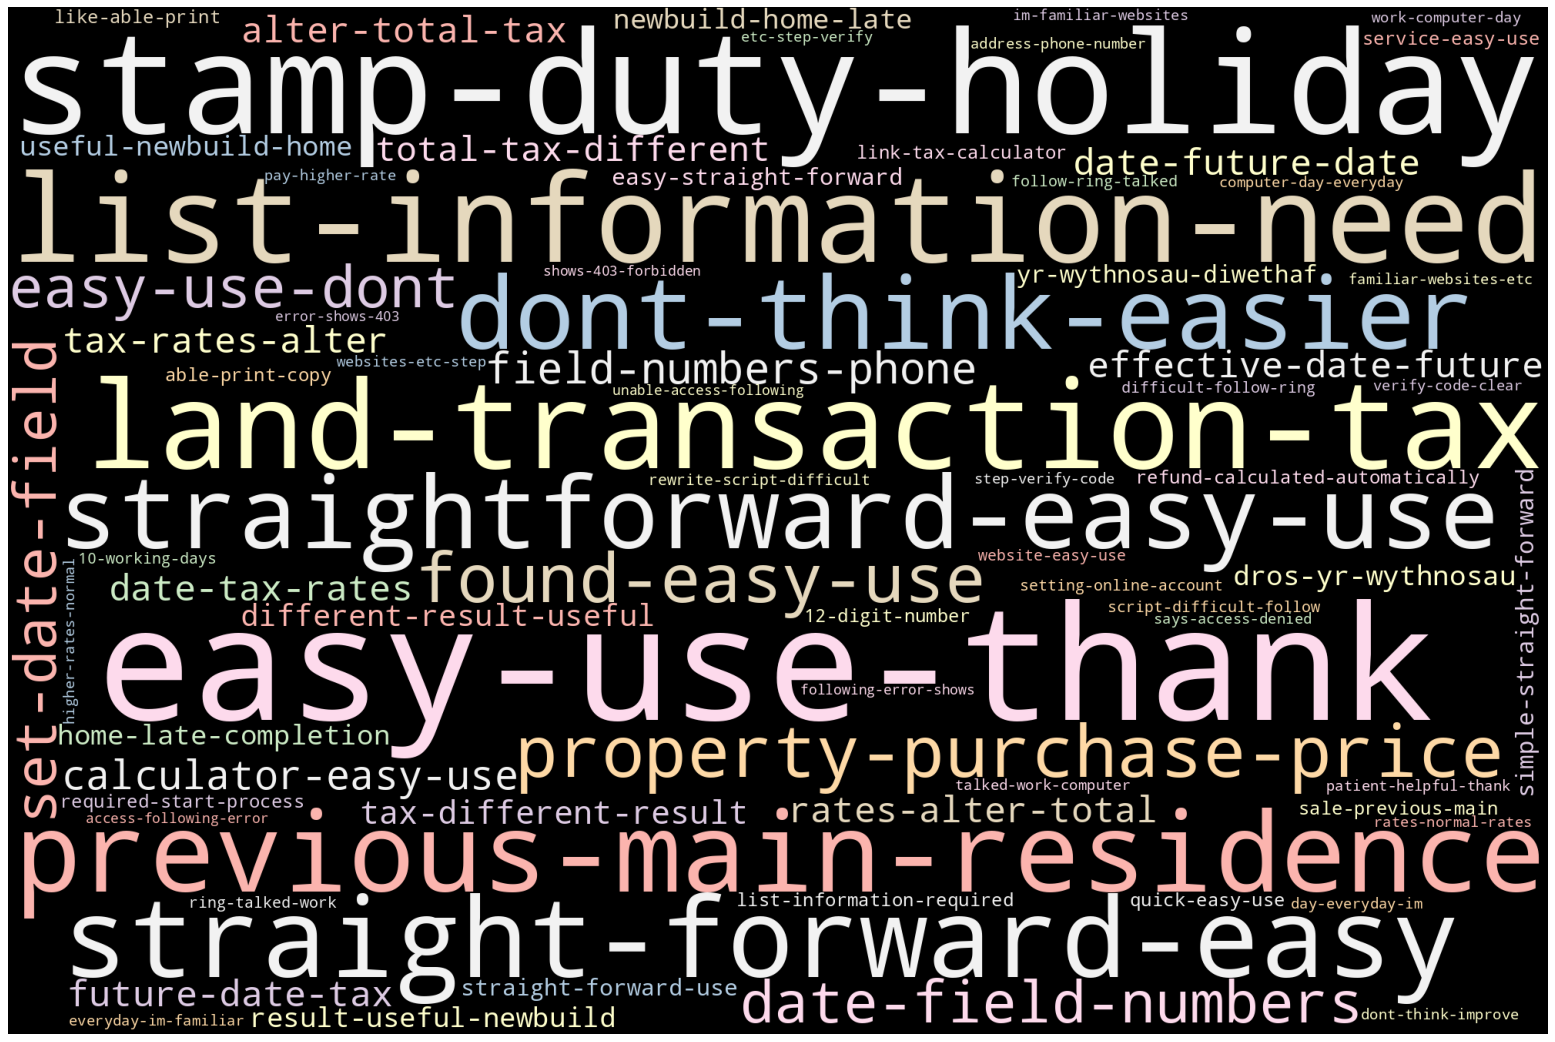

In [50]:
plot_cloud(word_cloud2)

In [51]:
df

,feedback,feedtype,len_feedback,clean_feedback,bigram_text,trigram_text
13,easy think form improved adding tick box buyer...,neutral,154,"[easy, think, form, improved, adding, tick, bo...",easy-think think-form form-improved improved-a...,easy-think-form think-form-improved form-impro...
18,shorten registration times automatic bridge,grumble,56,"[shorten, registration, times, automatic, bridge]",shorten-registration registration-times times-...,shorten-registration-times registration-times-...
20,lot information requested repetitive,grumble,63,"[lot, information, requested, repetitive]",lot-information information-requested requeste...,lot-information-requested information-requeste...
21,10 days approve registration,neutral,50,"[10, days, approve, registration]",10-days days-approve approve-registration,10-days-approve days-approve-registration
22,website easy use turnaround time long,neutral,77,"[website, easy, use, turnaround, time, long]",website-easy easy-use use-turnaround turnaroun...,website-easy-use easy-use-turnaround use-turna...
...,...,...,...,...,...,...
2960,feedback thought thee sessions right length in...,compliment,82,"[feedback, thought, thee, sessions, right, len...",feedback-thought thought-thee thee-sessions se...,feedback-thought-thee thought-thee-sessions th...
2961,general found wra helpful dealing technical qu...,compliment,140,"[general, found, wra, helpful, dealing, techni...",general-found found-wra wra-helpful helpful-de...,general-found-wra found-wra-helpful wra-helpfu...
2962,said earlier helpful patient pass feedback lin...,compliment,205,"[said, earlier, helpful, patient, pass, feedba...",said-earlier earlier-helpful helpful-patient p...,said-earlier-helpful earlier-helpful-patient h...
2963,guidelines appear indicate 40000 exemption app...,grumble,441,"[guidelines, appear, indicate, 40000, exemptio...",guidelines-appear appear-indicate indicate-400...,guidelines-appear-indicate appear-indicate-400...


***Copying n-grams into new dataframe***

In [52]:
new_df = df[['bigram_text','trigram_text','len_feedback']].copy()

In [53]:
df = df.drop(['bigram_text','trigram_text','len_feedback'], axis=1)

In [54]:
df

,feedback,feedtype,clean_feedback
13,easy think form improved adding tick box buyer...,neutral,"[easy, think, form, improved, adding, tick, bo..."
18,shorten registration times automatic bridge,grumble,"[shorten, registration, times, automatic, bridge]"
20,lot information requested repetitive,grumble,"[lot, information, requested, repetitive]"
21,10 days approve registration,neutral,"[10, days, approve, registration]"
22,website easy use turnaround time long,neutral,"[website, easy, use, turnaround, time, long]"
...,...,...,...
2960,feedback thought thee sessions right length in...,compliment,"[feedback, thought, thee, sessions, right, len..."
2961,general found wra helpful dealing technical qu...,compliment,"[general, found, wra, helpful, dealing, techni..."
2962,said earlier helpful patient pass feedback lin...,compliment,"[said, earlier, helpful, patient, pass, feedba..."
2963,guidelines appear indicate 40000 exemption app...,grumble,"[guidelines, appear, indicate, 40000, exemptio..."


***Overall View***

In [55]:
df['feedtype'] = df['feedtype'].replace(['compliment','grumble','neutral'],[1,0,2])

In [56]:
df

,feedback,feedtype,clean_feedback
13,easy think form improved adding tick box buyer...,2,"[easy, think, form, improved, adding, tick, bo..."
18,shorten registration times automatic bridge,0,"[shorten, registration, times, automatic, bridge]"
20,lot information requested repetitive,0,"[lot, information, requested, repetitive]"
21,10 days approve registration,2,"[10, days, approve, registration]"
22,website easy use turnaround time long,2,"[website, easy, use, turnaround, time, long]"
...,...,...,...
2960,feedback thought thee sessions right length in...,1,"[feedback, thought, thee, sessions, right, len..."
2961,general found wra helpful dealing technical qu...,1,"[general, found, wra, helpful, dealing, techni..."
2962,said earlier helpful patient pass feedback lin...,1,"[said, earlier, helpful, patient, pass, feedba..."
2963,guidelines appear indicate 40000 exemption app...,0,"[guidelines, appear, indicate, 40000, exemptio..."


In [57]:
def cleanText(raw_text, remove_stopwords=False, stemming=False, split_text=False):
    txt = BeautifulSoup(raw_text, 'lxml').get_text()
    letter_only = re.sub("[^a-zA-Z]", " ", txt) 
    words = letter_only.lower().split()  
    
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    if stemming==True:
        stemmer = SnowballStemmer('english') 
        words = [stemmer.stem(w) for w in words]
        
    if split_text==True:
        return (words)
    
    return( " ".join(words))

In [58]:
df['cleaned_feedback'] = df['feedback'].apply(cleanText, remove_stopwords=True, stemming=True, split_text=True)

In [59]:
df

,feedback,feedtype,clean_feedback,cleaned_feedback
13,easy think form improved adding tick box buyer...,2,"[easy, think, form, improved, adding, tick, bo...","[easi, think, form, improv, ad, tick, box, buy..."
18,shorten registration times automatic bridge,0,"[shorten, registration, times, automatic, bridge]","[shorten, registr, time, automat, bridg]"
20,lot information requested repetitive,0,"[lot, information, requested, repetitive]","[lot, inform, request, repetit]"
21,10 days approve registration,2,"[10, days, approve, registration]","[day, approv, registr]"
22,website easy use turnaround time long,2,"[website, easy, use, turnaround, time, long]","[websit, easi, use, turnaround, time, long]"
...,...,...,...,...
2960,feedback thought thee sessions right length in...,1,"[feedback, thought, thee, sessions, right, len...","[feedback, thought, thee, session, right, leng..."
2961,general found wra helpful dealing technical qu...,1,"[general, found, wra, helpful, dealing, techni...","[general, found, wra, help, deal, technic, que..."
2962,said earlier helpful patient pass feedback lin...,1,"[said, earlier, helpful, patient, pass, feedba...","[said, earlier, help, patient, pass, feedback,..."
2963,guidelines appear indicate 40000 exemption app...,0,"[guidelines, appear, indicate, 40000, exemptio...","[guidelin, appear, indic, exempt, appli, trans..."


In [60]:
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_feedback'],df['feedtype'] , test_size=0.1, random_state=0)

In [61]:
def modelEvaluation(predictions):
    '''
    Print model evaluation to predicted result 
    '''
    print ("\nAccuracy on validation set: {:.4f}".format(accuracy_score(y_test, predictions)))
    print ("\nClassification report : \n", metrics.classification_report(y_test, predictions))
    print ("\nConfusion Matrix : \n", metrics.confusion_matrix(y_test, predictions))

     # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = len(np.unique(y_test))
    y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
    y_score = mnb1.predict_proba(countVect1.transform(X_test_str))
    for i in range(n_classes):
        fpr[i], tpr[i], _ = metrics.roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])

    # Plot confusion matrix as heatmap
    cm = metrics.confusion_matrix(y_test, predictions)
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

**NAIVE BAYES using Countvec**

Before building the models, text data is preprocessed using CountVectorizer and TF-IDF techniques. CountVectorizer converts the text data into a matrix of token counts, while TF-IDF takes into account the frequency of each word in a document and the frequency of the word across all documents. Both techniques are applied separately and the resulting matrix is used as input to the models. Three models were trained on the preprocessed data: Naive Bayes, Support Vector Machine and Random Forest classifier. 


In [65]:
from sklearn.model_selection import RandomizedSearchCV

In [62]:
X_train_str = [' '.join(text) for text in X_train]

In [63]:
X_test_str = [' '.join(text) for text in X_test]

In [64]:
countVect1 = CountVectorizer() 
X_train_countVect1 = countVect1.fit_transform(X_train_str)
mnb1 = MultinomialNB()
mnb1.fit(X_train_countVect1, y_train)

MultinomialNB()

In [68]:
from sklearn.naive_bayes import BernoulliNB

BNB = BernoulliNB()
BNB.fit(X_train_countVect1, y_train)

BernoulliNB()


Accuracy on validation set: 0.7697

Classification report : 
               precision    recall  f1-score   support

           0       0.70      0.69      0.70        45
           1       0.93      0.89      0.91        76
           2       0.51      0.58      0.55        31

    accuracy                           0.77       152
   macro avg       0.72      0.72      0.72       152
weighted avg       0.78      0.77      0.77       152


Confusion Matrix : 
 [[31  2 12]
 [ 3 68  5]
 [10  3 18]]


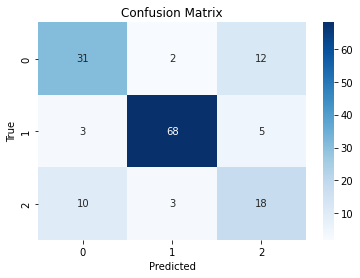

In [69]:
predictions = mnb1.predict(countVect1.transform(X_test_str))
modelEvaluation(predictions)


Accuracy on validation set: 0.6579

Classification report : 
               precision    recall  f1-score   support

           0       0.66      0.47      0.55        45
           1       0.73      0.92      0.81        76
           2       0.38      0.29      0.33        31

    accuracy                           0.66       152
   macro avg       0.59      0.56      0.56       152
weighted avg       0.64      0.66      0.64       152


Confusion Matrix : 
 [[21 14 10]
 [ 1 70  5]
 [10 12  9]]


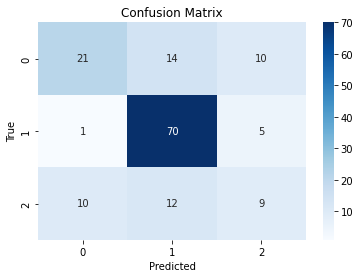

In [70]:
predictions = BNB.predict(countVect1.transform(X_test_str))
modelEvaluation(predictions)

**Multinomial Hyperparameter**

Best parameters: {'fit_prior': True, 'alpha': 1.873817422860383}
Best cross-validation score: 0.7426
Accuracy score: 0.8838


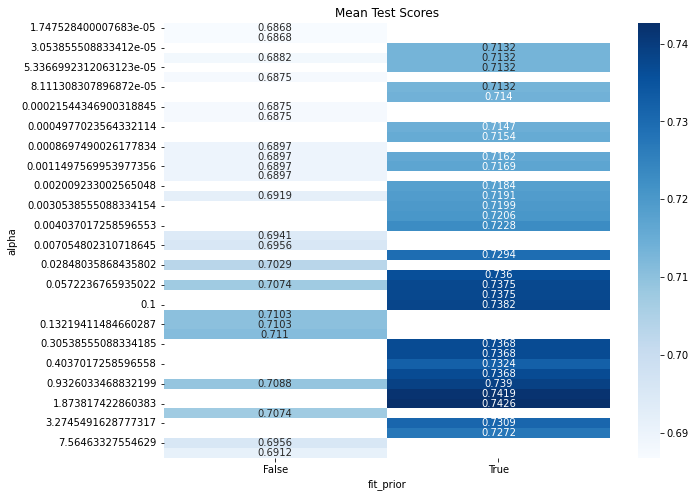

In [66]:
# define the hyperparameters to search over
param_dist = {
    'alpha': np.logspace(-5, 1, 100),
    'fit_prior': [True, False],
}

# define the search
search = RandomizedSearchCV(mnb1, param_distributions=param_dist, n_iter=50, cv=5, random_state=42)

search.fit(X_train_countVect1, y_train)

# get the best model
best_mnb1 = search.best_estimator_
predictions1 = best_mnb1.predict(X_train_countVect1)
accuracy = best_mnb1.score(X_train_countVect1, y_train)

print("Best parameters: {}".format(search.best_params_))
print("Best cross-validation score: {:.4f}".format(search.best_score_))
print("Accuracy score: {:.4f}".format(accuracy))

# Extract the results of the RandomizedSearchCV
results = search.cv_results_

# Create a DataFrame from the results
df = pd.DataFrame(results)

# Pivot the DataFrame to make the alpha and fit_prior columns the rows and the mean_test_score column the values
heatmap_df = df.pivot(index='param_alpha', columns='param_fit_prior', values='mean_test_score')

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_df, cmap='Blues', annot=True, fmt='.4g')

# Set the labels
plt.xlabel('fit_prior')
plt.ylabel('alpha')
plt.title('Mean Test Scores')
plt.show()



**NAIVE BAYES using TFIDF**

In [71]:
tfidf = TfidfVectorizer(min_df=5)
X_train_tfidf = tfidf.fit_transform(X_train_str)

In [72]:
mnb2 = MultinomialNB()
mnb2.fit(X_train_tfidf, y_train)

MultinomialNB()

In [73]:
BNB1 = BernoulliNB()
BNB1.fit(X_train_tfidf, y_train)

BernoulliNB()


Accuracy on validation set: 0.7961

Classification report : 
               precision    recall  f1-score   support

           0       0.72      0.80      0.76        45
           1       0.90      0.93      0.92        76
           2       0.61      0.45      0.52        31

    accuracy                           0.80       152
   macro avg       0.74      0.73      0.73       152
weighted avg       0.79      0.80      0.79       152


Confusion Matrix : 
 [[36  4  5]
 [ 1 71  4]
 [13  4 14]]


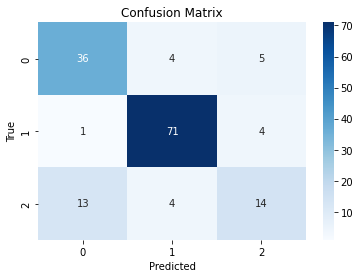

In [74]:
predictions = mnb2.predict(tfidf.transform(X_test_str))
modelEvaluation(predictions)


Accuracy on validation set: 0.7303

Classification report : 
               precision    recall  f1-score   support

           0       0.78      0.64      0.71        45
           1       0.81      0.88      0.84        76
           2       0.47      0.48      0.48        31

    accuracy                           0.73       152
   macro avg       0.69      0.67      0.68       152
weighted avg       0.73      0.73      0.73       152


Confusion Matrix : 
 [[29  7  9]
 [ 1 67  8]
 [ 7  9 15]]


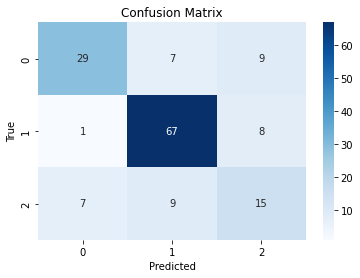

In [75]:
predictions = BNB1.predict(tfidf.transform(X_test_str))
modelEvaluation(predictions)

**SVM MODEL using countvect**

In [76]:
from sklearn.svm import SVC

In [77]:
svm1 = SVC(kernel='linear', random_state = 10)
svm1.fit(X_train_countVect1, y_train)

SVC(kernel='linear', random_state=10)


Accuracy on validation set: 0.7039

Classification report : 
               precision    recall  f1-score   support

           0       0.62      0.51      0.56        45
           1       0.87      0.88      0.88        76
           2       0.45      0.55      0.49        31

    accuracy                           0.70       152
   macro avg       0.65      0.65      0.64       152
weighted avg       0.71      0.70      0.70       152


Confusion Matrix : 
 [[23  5 17]
 [ 5 67  4]
 [ 9  5 17]]


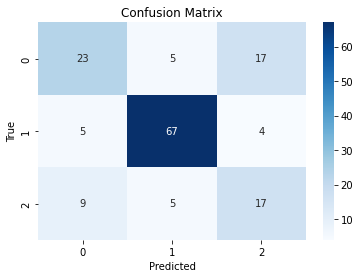

In [78]:
predictions = svm1.predict(countVect1.transform(X_test_str))
modelEvaluation(predictions)

 **SVM model using TFIDF**

In [79]:
svm2 = SVC(kernel='linear', random_state = 10)
svm2.fit(X_train_tfidf, y_train)

SVC(kernel='linear', random_state=10)


Accuracy on validation set: 0.7697

Classification report : 
               precision    recall  f1-score   support

           0       0.68      0.71      0.70        45
           1       0.90      0.91      0.90        76
           2       0.57      0.52      0.54        31

    accuracy                           0.77       152
   macro avg       0.72      0.71      0.71       152
weighted avg       0.77      0.77      0.77       152


Confusion Matrix : 
 [[32  4  9]
 [ 4 69  3]
 [11  4 16]]


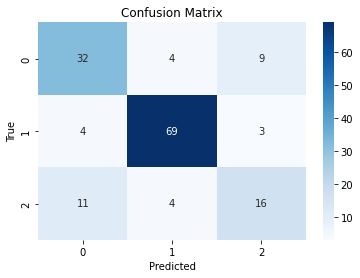

In [80]:
predictions = svm2.predict(tfidf.transform(X_test_str))
modelEvaluation(predictions)

In [81]:
from sklearn.ensemble import RandomForestClassifier
model_1 = RandomForestClassifier()

In [82]:
model_1.fit(X_train_countVect1, y_train)

RandomForestClassifier()


Accuracy on validation set: 0.7500

Classification report : 
               precision    recall  f1-score   support

           0       0.74      0.62      0.67        45
           1       0.86      0.92      0.89        76
           2       0.48      0.52      0.50        31

    accuracy                           0.75       152
   macro avg       0.70      0.69      0.69       152
weighted avg       0.75      0.75      0.75       152


Confusion Matrix : 
 [[28  4 13]
 [ 2 70  4]
 [ 8  7 16]]


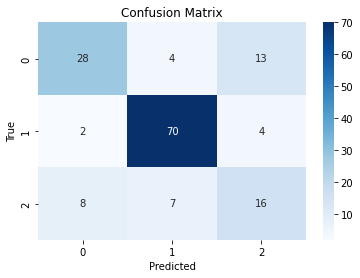

In [83]:
predictions = model_1.predict(countVect1.transform(X_test_str))
modelEvaluation(predictions)

** Random Forest Hyperparater Tunning**

In [85]:
model_2 = RandomForestClassifier()
model_2.fit(X_train_tfidf, y_train)

RandomForestClassifier()


Accuracy on validation set: 0.7105

Classification report : 
               precision    recall  f1-score   support

           0       0.68      0.58      0.63        45
           1       0.87      0.86      0.86        76
           2       0.44      0.55      0.49        31

    accuracy                           0.71       152
   macro avg       0.66      0.66      0.66       152
weighted avg       0.72      0.71      0.72       152


Confusion Matrix : 
 [[26  5 14]
 [ 3 65  8]
 [ 9  5 17]]


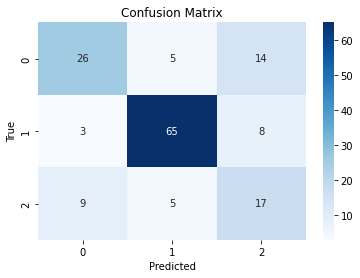

In [86]:
predictions = model_2.predict(tfidf.transform(X_test_str))
modelEvaluation(predictions)

Best parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}
Best cross-validation score: 0.7110
Accuracy score: 0.9912


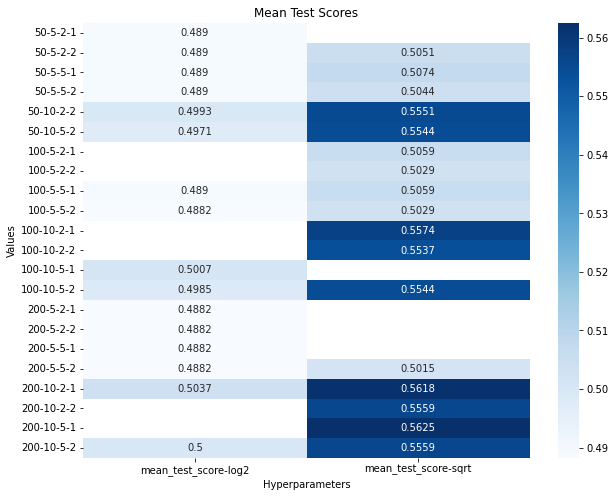

In [84]:
# define the hyperparameters to search over
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

# define the search
search = RandomizedSearchCV(RandomForestClassifier(random_state=42), param_distributions=param_dist, n_iter=50, cv=5, random_state=42)

search.fit(X_train_countVect1, y_train)

# get the best model
best_rf = search.best_estimator_
predictions = best_rf.predict(X_train_countVect1)
accuracy = best_rf.score(X_train_countVect1, y_train)

print("Best parameters: {}".format(search.best_params_))
print("Best cross-validation score: {:.4f}".format(search.best_score_))
print("Accuracy score: {:.4f}".format(accuracy))

# Extract the results of the RandomizedSearchCV
results = search.cv_results_

# Create a DataFrame from the results
df = pd.DataFrame(results)

# Pivot the DataFrame to make the hyperparameters the rows and the mean_test_score column the values
heatmap_df = df.pivot_table(index=[f'param_{param}' for param in param_dist.keys()], values='mean_test_score')

# Reshape the DataFrame to have columns for each hyperparameter
heatmap_df = heatmap_df.unstack(level=-1)

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_df, cmap='Blues', annot=True, fmt='.4g')

# Set the labels
plt.xlabel('Hyperparameters')
plt.ylabel('Values')
plt.title('Mean Test Scores')
plt.show()